# DBSCAN

In [78]:
import pandas as pd
import numpy as np
from math import pi
from math import ceil, floor
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
import joblib
from tqdm import tqdm
import re
from IPython.display import clear_output
import mapply
mapply.init(n_workers=7, progressbar=True)
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

In [4]:
cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
        'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

cat_cols2 = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

cat_cols_f = ['party', 'date_day', 'date_month', 'date_year', 'state', 'incident_characteristics1']

orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
        'max_age_participants', 'n_participants_child', 'n_participants_teen',
        'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
        'n_arrested', 'n_unharmed', 'n_participants',
        'povertyPercentage', 'candidatevotes', 'totalvotes']

K_MIN = 2
K_MAX = 20

OUTLIERS_REM = 'remove_outliers_iqr'
#OUTLIERS_REM = 'flag'
#SCALER = 'std'
SCALER = 'minmax'

MODEL_NAMES = ['Original Model', 'Augmented Model', 'Indicators Model', 'Original Reduced Model', 'Augmented Reduced Model', 'Indicators Reduced Model']

def remove_outliers_iqr(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

def prepare(df, scaler='std', with_original=True, with_indicators=True):
    df.loc[:, cat_cols2] = df.loc[:, cat_cols2].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        if not with_original:
            return None
        numerical_df = numerical_df[orig_num_cols]
    elif not with_original:
        numerical_df = numerical_df[[col for col in numerical_df.columns if col not in orig_num_cols]]

    if scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        
    numerical_scaled = scaler.fit_transform(numerical_df.values)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, k_min, k_max, initial_centroids=None, max_iter=300):
    models = []
    for i in range(k_min):
        models.append(None)

    for k in tqdm(range(k_min, k_max+1)):
        if initial_centroids is None:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter)
        else:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter, init=initial_centroids)
        model.fit(df)
        models.append(model)

    return models


def scores(models, df, model_name, k_min, k_max, sample_size=-1, n_samples=1):
    SSEs = []
    separations = []
    silhouettess = []

    for i in range(0, k_min):
        SSEs.append(None)
        separations.append(None)
        silhouettess.append([])
    
    models = models[k_min:k_max+1]

    k = k_min
    for model in models:
        SSEs.append(model.inertia_)
        separations.append(metrics.davies_bouldin_score(df, model.labels_))

        silhouettes = []

        if n_samples > 0:
            print(f'{model_name}:')
            print(f'k = {k}')
            
            for j in tqdm(range(0, n_samples)):
                if sample_size == -1:
                    sample_size = df.shape[0]   
                sampled_indeces = random.sample(range(df.shape[0]), sample_size)
                sampled_points = [df.iloc[i] for i in sampled_indeces]
                sampled_labels = [model.labels_[i] for i in sampled_indeces]
                silhouettes.append(silhouette_score(sampled_points, sampled_labels))
            clear_output(wait=True)

        silhouettess.append(silhouettes)
        k += 1
    
    scoress_dict = {
        'Model': model_name,
        'SSE': SSEs,
        'Separation': separations,
        'Silhouette': silhouettess
    }

    return scoress_dict


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    combined = list(zip(columns, max_scores))
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
    sorted_cols = [item for item, score in sorted_combined]
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(model_scores, model_names, k_mins, k_maxs):
    N = len(model_scores)
    labels = list(model_scores[0].keys())+['']
    labels.remove('Model')

    plt.figure(figsize=(4*N, 18))
    
    for j in range(len(labels)):
        label = labels[j]
        for z, i in zip(range(N), np.arange(1, N*4, 4)):
            model_score = model_scores[z]
            model_name = model_names[z]
            k_min = k_mins[z]
            k_max = k_maxs[z]
            k_values = np.arange(k_min, k_max+1)
            if label == 'Silhouette':
                mean_scores = []
                silhouettess = model_score['Silhouette']
                for k in k_values:
                    mean_scores.append(np.mean(np.array(silhouettess[k])))
                values = mean_scores
                plt.subplot(N, 4, i+j)
                plt.ylabel('Silhouette Mean')
            elif label == '':
                var_scores = []
                silhouettess = model_score['Silhouette']
                for k in k_values:
                    var_scores.append(np.var(np.array(silhouettess[k])))
                values = var_scores
                plt.subplot(N, 4, i+j)
                plt.ylabel('Silhouette Variance')
                mean_plotted = False
            else:
                values = model_score[label][k_min:k_max+1]
                plt.subplot(N, 4, i+j)
                plt.ylabel(label)
            plt.plot(k_values, values, marker='o')
            plt.title(model_name)
            plt.xticks(k_values[::2])
            plt.xlabel('Number of clusters')
            
    plt.tight_layout()
    plt.show()


def generate_random_df(stats_df, sample_size=1):
    columns = stats_df['Attribute'].tolist()
    random_row = {}
    for j in tqdm(range(len(columns))):
        col = columns[j]
        to_sample_from = stats_df[stats_df['Attribute'] == col]
        if to_sample_from['Possible Values'][j] is not None:
            random_row[col] = np.random.choice(to_sample_from['Possible Values'][j], size=sample_size)
        else:
            random_row[col] = np.random.uniform(to_sample_from['Min Value'][j], to_sample_from['Max Value'][j], size=sample_size)
    random_df = pd.DataFrame(random_row)
    return random_df



def augment(df):
    # from data cleaning ----------------------------------------------------------------------------------
    augmented_participants = df.copy()

    PREFIX = lambda c: f'p_{c[2:]}'

    participants_cols = ['n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']

    # indicators

    # Age Change wrt the mean in the same (month, congressional_district)
    for col in participants_cols:
        augmented_participants[PREFIX(col)] = augmented_participants[col] / augmented_participants['n_participants']

    augmented_age = augmented_participants.copy()
    PREFIX = lambda cs: [f'month_cd_change_{c}' for c in cs]

    augmented_age = augmented_age.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
    augmented_age = augmented_age.sort_index()

    cols = ['min_age_participants', 'avg_age_participants', 'max_age_participants']
    mean_val = augmented_age.groupby(augmented_age.index.names)[cols].mean()
    augmented_age[PREFIX(cols)] = augmented_age[cols] - mean_val

    augmented_age = augmented_age.reset_index()

    # Age Change wrt the mean in the same (month, state)
    PREFIX = lambda cs: [f'year_state_change_{c}' for c in cs]

    augmented_age = augmented_age.set_index(['date_year', 'state'])
    augmented_age = augmented_age.sort_index()

    cols = ['min_age_participants', 'avg_age_participants', 'max_age_participants']
    mean_val = augmented_age.groupby(augmented_age.index.names)[cols].mean()
    augmented_age[PREFIX(cols)] = augmented_age[cols] - mean_val

    augmented_age = augmented_age.reset_index()


    # Number of participants wrt the sum in that (month, congressional_district)
    augmented_p_ratio = augmented_age.copy()
    PREFIX = lambda cs: [f'month_cd_ratio_{c[2:]}' for c in cs]

    new_params = [p + '_ratio' for p in participants_cols]

    augmented_p_ratio = augmented_p_ratio.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
    augmented_p_ratio = augmented_p_ratio.sort_index()
    sums = augmented_p_ratio.groupby(augmented_p_ratio.index.names)[participants_cols].sum()

    augmented_p_ratio[PREFIX(participants_cols)] = augmented_p_ratio[participants_cols].div(sums, axis=0)
    augmented_p_ratio = augmented_p_ratio.reset_index()

    # Number of participants wrt the sum in that (month, state)
    PREFIX = lambda cs: [f'year_state_ratio_{c[2:]}' for c in cs]

    new_params = [p + '_ratio' for p in participants_cols]

    augmented_p_ratio = augmented_p_ratio.set_index(['date_year', 'state'])
    augmented_p_ratio = augmented_p_ratio.sort_index()
    sums = augmented_p_ratio.groupby(augmented_p_ratio.index.names)[participants_cols].sum()

    augmented_p_ratio[PREFIX(participants_cols)] = augmented_p_ratio[participants_cols].div(sums, axis=0)
    augmented_p_ratio = augmented_p_ratio.reset_index()

    # Replace NaNs (0/0) with 0
    augmented_p_ratio = augmented_p_ratio.fillna(0)

    augmented_incidents = augmented_p_ratio.copy()
    PREFIX = lambda _: 'month_cd_incidents'

    augmented_incidents = augmented_incidents.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
    augmented_incidents = augmented_incidents.sort_index()
    augmented_incidents['month_cd_incidents'] = augmented_incidents.groupby(augmented_incidents.index.names).size()
    augmented_incidents['month_cd_votes_incidents'] = augmented_incidents['month_cd_incidents'] / augmented_incidents['totalvotes']

    augmented_incidents = augmented_incidents.reset_index()

    augmented_incidents = augmented_incidents.set_index(['date_year', 'state'])
    augmented_incidents = augmented_incidents.sort_index()
    augmented_incidents['year_state_incidents'] = augmented_incidents.groupby(augmented_incidents.index.names).size()

    augmented_incidents = augmented_incidents.reset_index()

    augmented_population = augmented_incidents.copy()

    votes = df.copy()
    votes = votes[['date_year', 'state', 'congressional_district', 'totalvotes']]
    votes = votes.set_index(['date_year', 'state', 'congressional_district'])
    votes = votes.sort_index()

    state_votes = votes.groupby(['date_year', 'state']).sum()

    augmented_population = augmented_population.set_index(['date_year', 'state', 'congressional_district'])
    augmented_population = augmented_population.sort_index()

    cd_population = augmented_population['totalvotes'] * augmented_population['state_population'] // state_votes['totalvotes']
    cd_population.dropna(inplace=True)

    augmented_population['cd_population'] = cd_population

    augmented_population = augmented_population.reset_index()

    augmented_party = augmented_population.copy()

    REP_df = augmented_party[augmented_party['party'] == 'REPUBLICAN'].copy()
    DEM_df = augmented_party[augmented_party['party'] == 'DEMOCRAT'].copy()
    REP_df['percentage_republican'] = REP_df['candidatevotes'] / REP_df['totalvotes']
    REP_df['percentage_democrat'] = 1 - (REP_df['candidatevotes'] / REP_df['totalvotes'])
    DEM_df['percentage_democrat'] = DEM_df['candidatevotes'] / DEM_df['totalvotes']
    DEM_df['percentage_republican'] = 1 - (DEM_df['candidatevotes'] / DEM_df['totalvotes'])
    augmented_party = pd.concat([REP_df, DEM_df], ignore_index=True).reset_index(drop=True).sample(frac=1)

    regex = re.compile('[^a-zA-Z0-9]')
    def rename(s):
        return regex.sub('_', s)

    k = 4

    augmented_charateristics = augmented_party.copy()

    vc = augmented_charateristics['incident_characteristics1'].value_counts()
    most_common = vc.head(k).index.tolist()

    augmented_charateristics = augmented_charateristics.set_index(['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1'])
    augmented_charateristics = augmented_charateristics.sort_index()
    something = augmented_charateristics.groupby(['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1']).size()
    morething = augmented_charateristics.groupby(['date_year', 'date_month', 'state', 'congressional_district']).size()

    # create a column for each of the k most common incident_characteristics1 plus a column for the others
    for c in most_common:
        nc = rename(c)
        nc = 'cd_month_' + nc
        perc_state_month = something.xs(c, level='incident_characteristics1') / morething
        perc_state_month.fillna(0, inplace=True)
        augmented_charateristics[nc] = perc_state_month
    nc = 'cd_month_OTHER'
    perc_state_month = 1 - augmented_charateristics[['cd_month_' + rename(c) for c in most_common]].sum(axis=1)
    augmented_charateristics[nc] = perc_state_month

    augmented_charateristics = augmented_charateristics.reset_index()

    augmented_charateristics = augmented_charateristics.set_index(['date_year', 'state', 'incident_characteristics1'])
    augmented_charateristics = augmented_charateristics.sort_index()
    something = augmented_charateristics.groupby(['date_year', 'state', 'incident_characteristics1']).size()
    morething = augmented_charateristics.groupby(['date_year', 'state']).size()

    # create a column for each of the k most common incident_characteristics1 plus a column for the others
    for c in most_common:
        nc = rename(c)
        nc = 'state_year_' + nc
        perc_state_month = something.xs(c, level='incident_characteristics1') / morething
        perc_state_month.fillna(0, inplace=True)
        augmented_charateristics[nc] = perc_state_month
    nc = 'state_year_OTHER'
    perc_state_month = 1 - augmented_charateristics[['state_year_' + rename(c) for c in most_common]].sum(axis=1)
    augmented_charateristics[nc] = perc_state_month

    df = augmented_charateristics.reset_index()
    
    return df

In [7]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')
df_init = df_init[df_init['state'] == 'CALIFORNIA']

if OUTLIERS_REM == 'flag':
    df_init = df_init[df_init['OUTLIER'] == 0]
else:
    for col in orig_num_cols:
        df_init = remove_outliers_iqr(df_init, col)

cols = cat_cols2 + orig_num_cols + ['state_population', 'timestamp']
df_init = df_init[cols]
df_init = augment(df_init)
#-------------------------------------------------------------------

summary_stats = pd.DataFrame({
    'Unique Values': df_init.nunique(),
    'Max Value': df_init.max(),
    'Min Value': df_init.min()
})
summary_stats['Possible Values'] = df_init.apply(lambda col: col.unique() if col.nunique() <= 8000 else None)
summary_stats = summary_stats.reset_index().rename(columns={'index': 'Attribute'})

random_df_init = generate_random_df(stats_df=summary_stats, sample_size=len(df_init.values))
random_df_init = augment(random_df_init)

100%|██████████| 77/77 [00:00<00:00, 1223.62it/s]


Dataset dimentions: (6026, 77)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (6026, 18)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (6026, 69)
Dataset dimentions without ouliers, with only numerical cols, only indicators: (6026, 51)


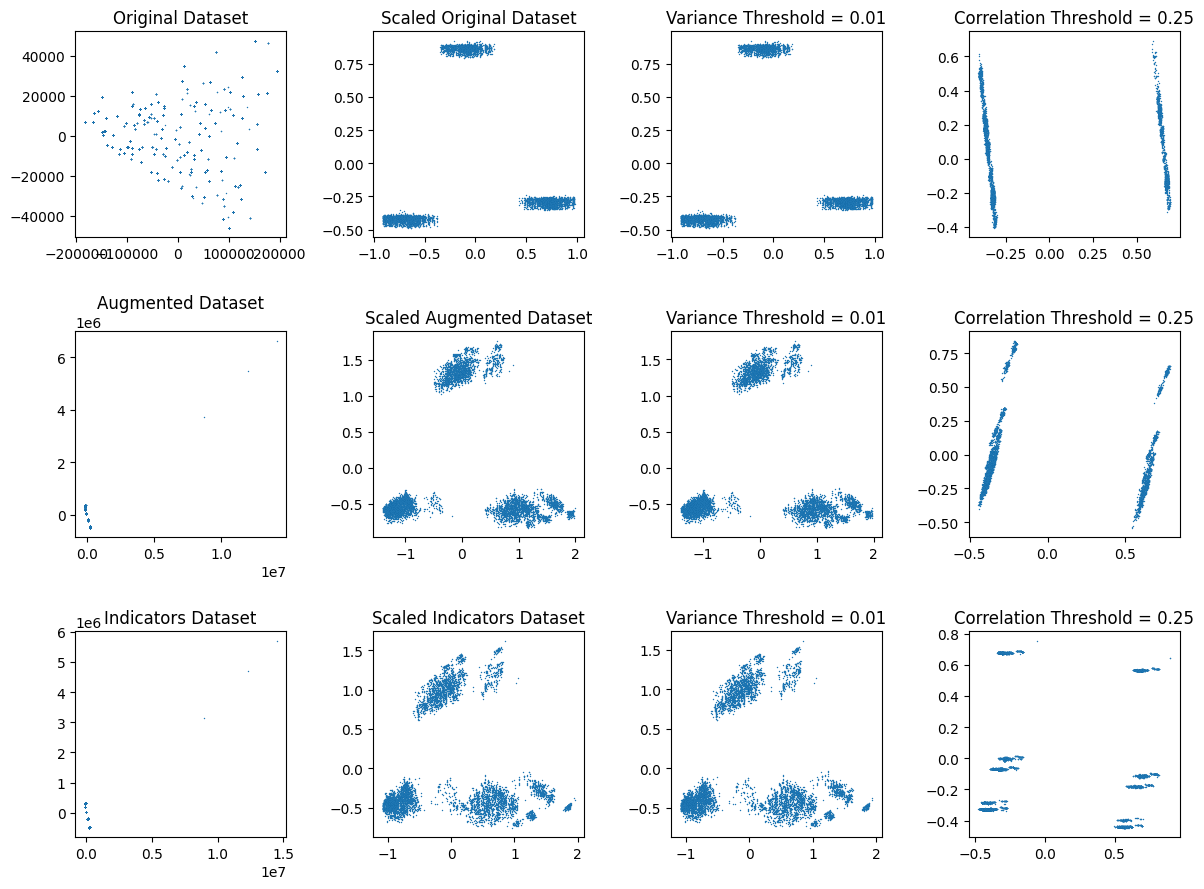

Original Dataset

Initial n_cols = 18

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 11
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 3
Index(['latitude', 'min_age_participants', 'n_killed'], dtype='object')

Augmented Dataset

Initial n_cols = 69

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 43
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes', 'state_population',
       'timestamp', 'p_killed', 'p_injured', 'p_arrested',
       'mon

In [8]:
df_orig, df_orig_s, scaler_orig = prepare(df=df_init, scaler=SCALER, with_indicators=False, with_original=True)
df, df_s, scaler = prepare(df=df_init, scaler=SCALER, with_indicators=True, with_original=True)
df_ind, df_ind_s, scaler_ind = prepare(df=df_init, scaler=SCALER, with_indicators=True, with_original=False)

print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, only indicators: {df_ind.shape}')

dataframes = [df_orig, df, df_ind]
scaled_dataframes = [df_orig_s, df_s, df_ind_s]
scalers = [scaler_orig, scaler, scaler_ind]
titles = ['Original Dataset', 'Augmented Dataset', 'Indicators Dataset']
N = len(dataframes)

if SCALER == 'minmax':
    var_thr = 0.01
    corr_thr = 0.25
else:
    var_thr = 1
    corr_thr = 0.25

reduced1s = []
reduced2s = []

for ds in scaled_dataframes:
    rs1 = features_reduction_var(ds, variance_threshold=var_thr)
    rs2 = features_reduction_corr(rs1, correlation_threshold=corr_thr)
    reduced1s.append(rs1)
    reduced2s.append(rs2)

scaled_dataframes = scaled_dataframes + reduced2s
dataframes = dataframes*2
scalers = scalers*2

plt.figure(figsize=(12, 9))

for d, ds, rs1, rs2, t, i in zip(dataframes, scaled_dataframes, reduced1s, reduced2s, titles, np.arange(1, N*4, 4)):

    pca = perform_PCA(df=d, n_components=2)
    pca_s = perform_PCA(df=ds, n_components=2)
    pca_rs1 = perform_PCA(df=rs1, n_components=2)
    pca_rs2 = perform_PCA(df=rs2, n_components=2)

    plt.subplot(3, 4, i)
    plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(t)

    plt.subplot(3, 4, i+1)
    plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Scaled {t}')

    plt.subplot(3, 4, i+2)
    plt.scatter(pca_rs1[:, 0], pca_rs1[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Variance Threshold = {var_thr}')

    plt.subplot(3, 4, i+3)
    plt.scatter(pca_rs2[:, 0], pca_rs2[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Correlation Threshold = {corr_thr}')

plt.tight_layout()
plt.show()

for ds, rs1, rs2, t in zip(scaled_dataframes, reduced1s, reduced2s, titles):
    print(f'{t}\n\nInitial n_cols = {ds.shape[1]}')
    print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs1.columns)}')
    print(rs1.columns)

    print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs2.columns)}')
    print(f'{rs2.columns}\n')

Dataset dimentions: (6026, 81)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (6026, 18)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (6026, 73)
Dataset dimentions without ouliers, with only numerical cols, only indicators: (6026, 55)


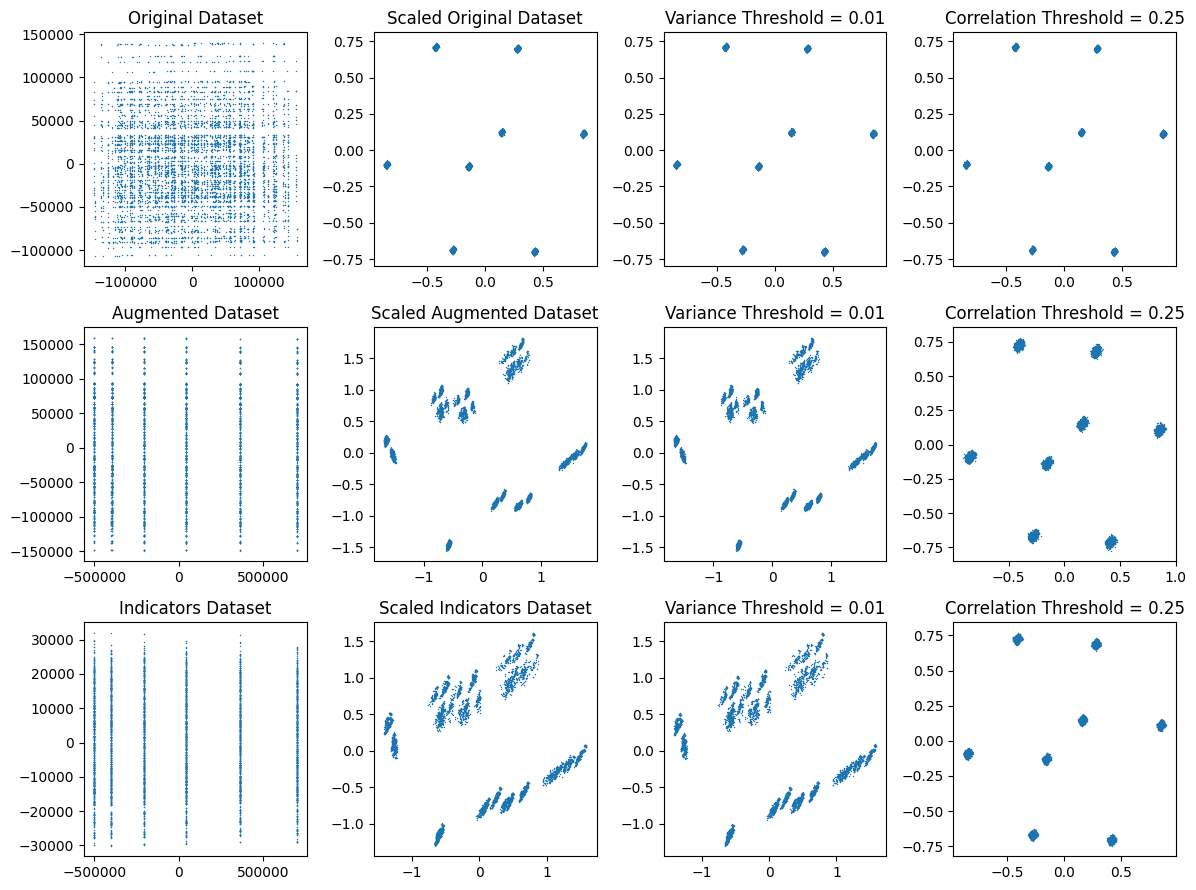

Original Dataset

Initial n_cols = 18

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 11
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 11
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n_arrested',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Augmented Dataset

Initial n_cols = 73

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 49
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_killed', 'n_injured', 'n

In [9]:
random_df_orig, random_df_orig_s, random_scaler_orig = prepare(df=random_df_init, scaler=SCALER, with_indicators=False, with_original=True)
random_df, random_df_s, random_scaler = prepare(df=random_df_init, scaler=SCALER, with_indicators=True, with_original=True)
random_df_ind, random_df_ind_s, random_scaler_ind = prepare(df=random_df_init, scaler=SCALER, with_indicators=True, with_original=False)

print(f'Dataset dimentions: {random_df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {random_df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {random_df.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, only indicators: {random_df_ind.shape}')

random_dataframes = [random_df_orig, random_df, random_df_ind]
random_scaled_dataframes = [random_df_orig_s, random_df_s, random_df_ind_s]
random_scalers = [random_scaler_orig, random_scaler, random_scaler_ind]
titles = ['Original Dataset', 'Augmented Dataset', 'Indicators Dataset']
N = len(random_dataframes)

if SCALER == 'minmax':
    var_thr = 0.01
    corr_thr = 0.25
else:
    var_thr = 1
    corr_thr = 0.25

reduced1s = []
reduced2s = []

for ds in random_scaled_dataframes:
    rs1 = features_reduction_var(ds, variance_threshold=var_thr)
    rs2 = features_reduction_corr(rs1, correlation_threshold=corr_thr)
    reduced1s.append(rs1)
    reduced2s.append(rs2)

random_scaled_dataframes = random_scaled_dataframes + reduced2s
random_dataframes = random_dataframes*2
random_scalers = random_scalers*2

plt.figure(figsize=(12, 9))

for d, ds, rs1, rs2, t, i in zip(random_dataframes, random_scaled_dataframes, reduced1s, reduced2s, titles, np.arange(1, N*4, 4)):

    pca = perform_PCA(df=d, n_components=2)
    pca_s = perform_PCA(df=ds, n_components=2)
    pca_rs1 = perform_PCA(df=rs1, n_components=2)
    pca_rs2 = perform_PCA(df=rs2, n_components=2)

    plt.subplot(3, 4, i)
    plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(t)

    plt.subplot(3, 4, i+1)
    plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Scaled {t}')

    plt.subplot(3, 4, i+2)
    plt.scatter(pca_rs1[:, 0], pca_rs1[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Variance Threshold = {var_thr}')

    plt.subplot(3, 4, i+3)
    plt.scatter(pca_rs2[:, 0], pca_rs2[:, 1], s=1, edgecolors='black', linewidths=0.001)
    plt.title(f'Correlation Threshold = {corr_thr}')

plt.tight_layout()
plt.show()

for ds, rs1, rs2, t in zip(random_scaled_dataframes, reduced1s, reduced2s, titles):
    print(f'{t}\n\nInitial n_cols = {ds.shape[1]}')
    print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs1.columns)}')
    print(rs1.columns)

    print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
    print(f'n_cols = {len(rs2.columns)}')
    print(f'{rs2.columns}\n')

Knee Method to estimate the best eps

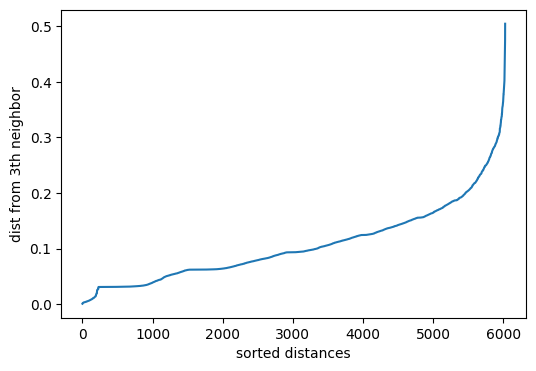

In [11]:
k = 3

dist = pdist(scaled_dataframes[0], 'euclidean')
dist = squareform(dist)

kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])
kth_distances_df = pd.DataFrame(kth_distances)
kth_distances_df = kth_distances_df.rolling(window=1).mean()
kth_distancess = kth_distances_df.values.tolist()
sorted_kth_distances = sorted(kth_distancess)

plt.figure(figsize=(6, 4))
plt.plot(range(0, len(kth_distancess)), sorted_kth_distances)
plt.ylabel(f'dist from {k}th neighbor', fontsize=10)
plt.xlabel('sorted distances', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

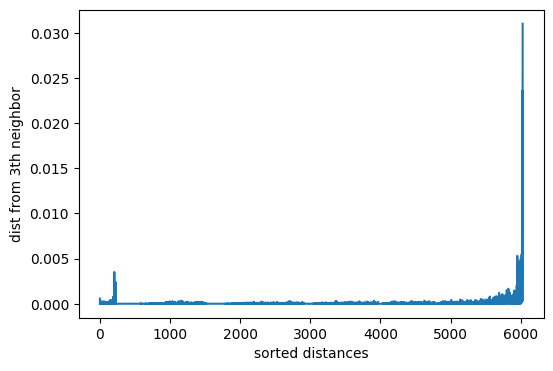

1.0531409023184501e-06


In [13]:
sorted_kth_distances_ = [x[0] for x in sorted_kth_distances[2:]]
secnd_grad = np.diff(sorted_kth_distances_, n=1)

plt.figure(figsize=(6, 4))
plt.plot(range(3, len(kth_distancess)), secnd_grad)
plt.ylabel(f'dist from {k}th neighbor', fontsize=10)
plt.xlabel('sorted distances', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

print(secnd_grad[5500])

In [57]:
max_min_samples = len(scaled_dataframes[0])
max_eps = np.max(pdist(scaled_dataframes[0], 'euclidean'))
min_samples_s = np.arange(1, max_min_samples, 600)
eps_s = np.arange(0.1, max_eps+1, 0.1)
print(max_min_samples)
print(max_eps)
print(len(min_samples_s))
print(len(eps_s))
print(len(min_samples_s)*len(eps_s))

6026
2.6277946570927972
11
36
396


In [61]:
silhouettes = []
models = []
for i in tqdm(range(len(min_samples_s))):
    min_samples = min_samples_s[i]
    for eps in eps_s:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(scaled_dataframes[0])
        models.append(dbscan)

100%|██████████| 11/11 [02:45<00:00, 15.02s/it]


In [64]:
for model in tqdm(models):
    n_lables = np.unique(model.labels_, return_counts=True)
    if len(np.unique(model.labels_)) > 1:
        sil = silhouette_score(scaled_dataframes[0], model.labels_)
    else:
        sil = -2
    silhouettes.append(sil)

100%|██████████| 396/396 [00:21<00:00, 18.10it/s]


In [93]:
best_models = []
best_sils = []
for scaled_dataframe in scaled_dataframes:
    min_min_samples = 1
    max_min_samples = len(scaled_dataframe)
    min_samples_step = 1000

    min_eps = 0.1
    max_eps = np.max(pdist(scaled_dataframe, 'euclidean'))
    eps_step = 0.5

    min_samples_s = np.arange(min_min_samples, max_min_samples, min_samples_step)
    eps_s = np.arange(min_eps, max_eps, eps_step)

    while len(range(min_min_samples, max_min_samples)) > 1:
        print(len(range(min_min_samples, max_min_samples)))
        silhouettes = []
        models = []

        i = 1
        for min_samples in tqdm(min_samples_s):
            for eps in eps_s:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                dbscan.fit(scaled_dataframe)
                models.append(dbscan)

        for model in tqdm(models):
            n_lables = np.unique(model.labels_, return_counts=True)
            if len(np.unique(model.labels_)) > 1:
                sil = silhouette_score(scaled_dataframe, model.labels_)
            else:
                sil = -2
            silhouettes.append(sil)

        best_model = models[np.argmax(silhouettes)]

        max_min_samples = best_model.min_samples + min_samples_step
        min_min_samples = best_model.min_samples - min_samples_step + 1
        if min_min_samples < 1:
            min_min_samples = 1 + i
            i += 1
        min_samples_step = np.max([floor(len(range(min_min_samples, max_min_samples)) / 10), 1])
        min_samples_s = np.arange(min_min_samples, max_min_samples, min_samples_step)

    max_eps = best_model.eps + eps_step
    min_eps = np.max([best_model.eps - eps_step, 0.1])
    eps_s = np.arange(min_eps, max_eps, 0.1)
    models = []

    for eps in tqdm(eps_s):
        dbscan = DBSCAN(eps=eps, min_samples=best_model.min_samples)
        dbscan.fit(scaled_dataframe)
        models.append(dbscan)

    silhouettes = []
    for model in tqdm(models):
        n_lables = np.unique(model.labels_, return_counts=True)
        if len(np.unique(model.labels_)) > 1:
            sil = silhouette_score(scaled_dataframe, model.labels_)
        else:
            sil = -2
        silhouettes.append(sil)

    best_models.append(models[np.argmax(silhouettes)])
    best_sils.append(np.max(silhouettes))


print(best_model)
print(np.max(silhouettes))

6025


100%|██████████| 42/42 [00:03<00:00, 10.67it/s]


999


100%|██████████| 66/66 [00:12<00:00,  5.22it/s]


99


100%|██████████| 66/66 [00:15<00:00,  4.38it/s]


9


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


6025


100%|██████████| 70/70 [00:06<00:00, 10.72it/s]


999


100%|██████████| 110/110 [00:17<00:00,  6.20it/s]


197


100%|██████████| 110/110 [00:18<00:00,  6.06it/s]


37


100%|██████████| 130/130 [00:21<00:00,  6.13it/s]


5


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


6025


100%|██████████| 63/63 [00:07<00:00,  8.02it/s]


1999


100%|██████████| 99/99 [00:10<00:00,  9.07it/s]


397


100%|██████████| 99/99 [00:09<00:00, 10.64it/s]


77


100%|██████████| 99/99 [00:09<00:00, 10.53it/s]


13


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


6025


100%|██████████| 28/28 [00:02<00:00, 10.65it/s]


999


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


99


100%|██████████| 44/44 [00:11<00:00,  3.86it/s]


9


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


6025


100%|██████████| 28/28 [00:03<00:00,  9.09it/s]


1999


100%|██████████| 44/44 [00:05<00:00,  7.64it/s]


397


100%|██████████| 44/44 [00:05<00:00,  7.69it/s]


77


100%|██████████| 44/44 [00:05<00:00,  7.76it/s]


13


100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


6025


100%|██████████| 28/28 [00:03<00:00,  9.07it/s]


1999


100%|██████████| 44/44 [00:06<00:00,  7.08it/s]


397


100%|██████████| 44/44 [00:05<00:00,  7.77it/s]


77


100%|██████████| 44/44 [00:05<00:00,  7.79it/s]


13


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

DBSCAN(eps=0.6, min_samples=285)
0.44679123091929435


In [97]:
print(np.unique(best_models[np.argmax(best_sils)].labels_))
print(np.unique(best_models[np.argmax(best_sils)].labels_))

[0 1]


In [88]:
print(best_model)
n_lables = np.unique(best_model.labels_, return_counts=True)
if len(np.unique(best_model.labels_)) > 1:
    sil = silhouette_score(scaled_dataframes[0], best_model.labels_)
else:
    sil = -2
print(sil)

DBSCAN(eps=0.6, min_samples=2)
0.5129911611345482


In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=k)
dbscan.fit(scaled_dataframes[0])

points_pca = perform_PCA(df=reduced_orig, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=dbscan_orig_r.labels_, s=1, edgecolors='black', linewidths=0.001)

cluster_labels, cluster_counts = np.unique(dbscan_orig_r.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

print(f'Silhouette {silhouette_score(reduced_orig, dbscan_orig_r.labels_)}')

In [141]:
for m, eps in zip(models_orig, to_check):
    print(f'eps = {eps}-----------------')
    cluster_labels, cluster_counts = np.unique(m.labels_, return_counts=True)
    for l, c in zip(cluster_labels, cluster_counts):
        print(f'Cluster {l}: {c} points')
    if len(cluster_labels) > 1:
        print(f'Silhouette {silhouette_score(df_orig_s, m.labels_)}')

eps = 0.1-----------------
Cluster -1: 7650 points
eps = 0.6-----------------
Cluster -1: 7291 points
Cluster 0: 172 points
Cluster 1: 187 points
Silhouette -0.13254024384699664
eps = 1.1-----------------
Cluster -1: 5106 points
Cluster 0: 270 points
Cluster 1: 751 points
Cluster 2: 73 points
Cluster 3: 49 points
Cluster 4: 146 points
Cluster 5: 191 points
Cluster 6: 52 points
Cluster 7: 188 points
Cluster 8: 40 points
Cluster 9: 41 points
Cluster 10: 109 points
Cluster 11: 51 points
Cluster 12: 309 points
Cluster 13: 274 points
Silhouette -0.10243643966935015
eps = 1.6-----------------
Cluster -1: 3374 points
Cluster 0: 490 points
Cluster 1: 1132 points
Cluster 2: 78 points
Cluster 3: 146 points
Cluster 4: 100 points
Cluster 5: 68 points
Cluster 6: 468 points
Cluster 7: 81 points
Cluster 8: 63 points
Cluster 9: 59 points
Cluster 10: 38 points
Cluster 11: 43 points
Cluster 12: 80 points
Cluster 13: 90 points
Cluster 14: 44 points
Cluster 15: 403 points
Cluster 16: 415 points
Cluster 17

Cluster -1: 583 points
Cluster 0: 5960 points
Cluster 1: 388 points
Cluster 2: 719 points
Silhouette 0.1585058210115701


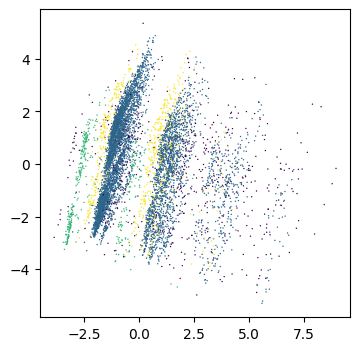

In [124]:
points_pca = perform_PCA(df=df_orig_s, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=m.labels_, s=1, edgecolors='black', linewidths=0.001)

cluster_labels, cluster_counts = np.unique(m.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

print(f'Silhouette {silhouette_score(df_orig_s, m.labels_)}')

Cluster -1: 366 points
Cluster 0: 1741 points
Cluster 1: 5509 points
Cluster 2: 19 points
Cluster 3: 8 points
Cluster 4: 7 points
Silhouette 0.3564491062387631


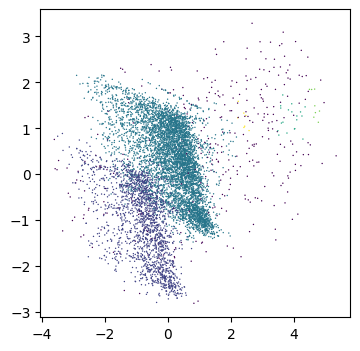

In [100]:
dbscan_orig_r = DBSCAN(eps=0.5, min_samples=k)
dbscan_orig_r.fit(reduced_orig)

points_pca = perform_PCA(df=reduced_orig, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=dbscan_orig_r.labels_, s=1, edgecolors='black', linewidths=0.001)

cluster_labels, cluster_counts = np.unique(dbscan_orig_r.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

print(f'Silhouette {silhouette_score(reduced_orig, dbscan_orig_r.labels_)}')